# 1. Introduce our data

In [56]:
import itertools
import pandas as pd
import numpy as np
from scipy.stats import boxcox
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix, average_precision_score, precision_score, f1_score, roc_auc_score
import pandas_profiling as pp
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [7]:
from pyxlsb import open_workbook as open_xlsb

data = []

with open_xlsb('Dataset.xlsb') as wb:
    with wb.get_sheet(1) as sheet:
        for row in sheet.rows():
            data.append([item.v for item in row])

data = pd.DataFrame(data[1:], columns=data[0])

In [7]:
data.head()

session_id  feature_1  feature_2  feature_3  feature_4  feature_5  \
0  67137182.0        0.0       -3.0        0.0        0.0        0.0   
1  67136918.0        0.0        0.0        0.0        0.0        0.0   
2  67135399.0        0.0        0.0        0.0        0.0        0.0   
3  67136514.0        0.0       12.0        0.0        0.0        0.0   
4  67136271.0        0.0        0.0        0.0        1.0       -6.0   

   feature_6  feature_7  feature_8  feature_9  ...    feature_184  \
0        1.0        0.0        1.0        0.0  ...            4.0   
1        0.0        0.0        0.0        0.0  ...            1.0   
2        0.0        0.0        1.0        0.0  ...            1.0   
3        0.0        0.0        1.0        0.0  ...            1.0   
4        0.0        0.0        1.0        0.0  ...            1.0   

   feature_185  feature_186  feature_187  feature_188  feature_189  \
0          2.0          1.0          1.0         12.0         12.0   
1          1.0          1.0          1.0          1.0          1.0   
2          1.0          1.0          1.0          1.0          1.0   
3          1.0          1.0          1.0          2.0          2.0   
4          1.0          1.0          1.0          3.0          3.0   

   feature_190  feature_191  feature_192  fraud  
0          1.0         12.0         12.0    0.0  
1          1.0          1.0          1.0    0.0  
2          1.0          1.0          1.0    0.0  
3          1.0          2.0          2.0    0.0  
4          1.0          3.0          3.0    0.0  

[5 rows x 194 columns]

In [394]:
data.shape

(94579, 194)

# 1.1 Check our data for anomalies

In [395]:
pd.options.display.max_columns = 200

In [396]:
data.describe()

session_id     feature_1     feature_2     feature_3     feature_4  \
count  9.457900e+04  94579.000000  94579.000000  94579.000000  94579.000000   
mean   5.163537e+07      0.071771      0.853805      0.027755      0.159930   
std    9.000736e+06      0.628175      5.797516      0.409324      0.366543   
min    3.723760e+07    -10.000000    -89.000000    -13.000000      0.000000   
25%    4.343542e+07      0.000000      0.000000      0.000000      0.000000   
50%    5.203958e+07      0.000000      0.000000      0.000000      0.000000   
75%    5.930783e+07      0.000000      0.000000      0.000000      0.000000   
max    6.713718e+07     23.000000     61.000000     15.000000      1.000000   

          feature_5     feature_6     feature_7     feature_8     feature_9  \
count  94579.000000  94579.000000  94579.000000  94579.000000  94579.000000   
mean      -5.323677      0.009632      0.712642      0.749236      0.159475   
std       16.767269      0.097670      3.883613      0.433455      0.366121   
min     -100.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      1.000000      0.000000   
75%        0.000000      0.000000      0.000000      1.000000      0.000000   
max        0.000000      1.000000     31.000000      1.000000      1.000000   

        feature_10    feature_11    feature_12    feature_13    feature_14  \
count  94579.00000  94579.000000  94579.000000  94579.000000  94579.000000   
mean       0.05165      0.103776      0.052284     12.366456      0.873312   
std        0.22132      0.304971      0.222601     66.914272      0.332625   
min        0.00000      0.000000      0.000000      0.000000      0.000000   
25%        0.00000      0.000000      0.000000      1.000000      1.000000   
50%        0.00000      0.000000      0.000000      1.000000      1.000000   
75%        0.00000      0.000000      0.000000      1.000000      1.000000   
max        1.00000      1.000000      1.000000   4041.000000      1.000000   

         feature_15    feature_16    feature_17    feature_18    feature_19  \
count  94579.000000  94579.000000  94579.000000  94579.000000  94579.000000   
mean       0.319828      0.076338     -9.508897     21.787553      2.496453   
std        0.466412      0.265540     22.852665     41.401367      9.981826   
min        0.000000      0.000000   -100.000000      0.000000      0.000000   
25%        0.000000      0.000000     -7.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000     13.000000      0.000000   
75%        1.000000      0.000000      0.000000     16.000000      5.000000   
max        1.000000      1.000000      0.000000    301.000000    229.000000   

         feature_20    feature_21    feature_22    feature_23    feature_24  \
count  94579.000000  94579.000000  94579.000000  94579.000000  94579.000000   
mean       0.086954      0.049609      0.033961     -4.138974      0.022870   
std        0.281769      0.217138      0.181130     16.401605      0.149489   
min        0.000000      0.000000      0.000000   -100.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      0.000000      1.000000   

         feature_25    feature_26    feature_27    feature_28    feature_29  \
count  94579.000000  94579.000000  94579.000000  94579.000000  94579.000000   
mean       0.256103      0.019560      0.028357      0.007676      0.110691   
std        4.308671      0.138485      0.165992      0.087277      0.313750   
min      -77.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000  

Here we can`t say good things about data. Let`s use another method.

In [47]:
pp.ProfileReport(data)

Firstly we should delete duplicate rows. In our data set there are 16 duplicate raws.

In [8]:
data['is_duplicated'] = data.duplicated()

In [9]:
data.head()

session_id  feature_1  feature_2  feature_3  feature_4  feature_5  \
0  67137182.0        0.0       -3.0        0.0        0.0        0.0   
1  67136918.0        0.0        0.0        0.0        0.0        0.0   
2  67135399.0        0.0        0.0        0.0        0.0        0.0   
3  67136514.0        0.0       12.0        0.0        0.0        0.0   
4  67136271.0        0.0        0.0        0.0        1.0       -6.0   

   feature_6  feature_7  feature_8  feature_9      ...        feature_185  \
0        1.0        0.0        1.0        0.0      ...                2.0   
1        0.0        0.0        0.0        0.0      ...                1.0   
2        0.0        0.0        1.0        0.0      ...                1.0   
3        0.0        0.0        1.0        0.0      ...                1.0   
4        0.0        0.0        1.0        0.0      ...                1.0   

   feature_186  feature_187  feature_188  feature_189  feature_190  \
0          1.0          1.0         12.0         12.0          1.0   
1          1.0          1.0          1.0          1.0          1.0   
2          1.0          1.0          1.0          1.0          1.0   
3          1.0          1.0          2.0          2.0          1.0   
4          1.0          1.0          3.0          3.0          1.0   

   feature_191  feature_192  fraud  is_duplicated  
0         12.0         12.0    0.0          False  
1          1.0          1.0    0.0          False  
2          1.0          1.0    0.0          False  
3          2.0          2.0    0.0          False  
4          3.0          3.0    0.0          False  

[5 rows x 195 columns]

In [9]:
duplicat = data[data['is_duplicated'] == True]

In [11]:
duplicat

session_id  feature_1  feature_2  feature_3  feature_4  feature_5  \
90956  37813695.0        0.0        0.0        0.0        0.0        0.0   
90960  37813695.0        0.0        0.0        0.0        0.0        0.0   
90962  37813695.0        0.0        0.0        0.0        0.0        0.0   
90966  37813695.0        0.0        0.0        0.0        0.0        0.0   
90968  37813695.0        0.0        0.0        0.0        0.0        0.0   
90973  37813695.0        0.0        0.0        0.0        0.0        0.0   
90977  37813695.0        0.0        0.0        0.0        0.0        0.0   
90979  37813695.0        0.0        0.0        0.0        0.0        0.0   
90984  37813695.0        0.0        0.0        0.0        0.0        0.0   
90989  37813695.0        0.0        0.0        0.0        0.0        0.0   
90993  37813695.0        0.0        0.0        0.0        0.0        0.0   
90997  37813695.0        0.0        0.0        0.0        0.0        0.0   
91004  37813695.0        0.0        0.0        0.0        0.0        0.0   
91012  37813695.0        0.0        0.0        0.0        0.0        0.0   
91029  37813695.0        0.0        0.0        0.0        0.0        0.0   
91050  37813695.0        0.0        0.0        0.0        0.0        0.0   

       feature_6  feature_7  feature_8  feature_9      ...        feature_185  \
90956        0.0        0.0        0.0        0.0      ...                0.0   
90960        0.0        0.0        0.0        0.0      ...                0.0   
90962        0.0        0.0        0.0        0.0      ...                0.0   
90966        0.0        0.0        0.0        0.0      ...                0.0   
90968        0.0        0.0        0.0        0.0      ...                0.0   
90973        0.0        0.0        0.0        0.0      ...                0.0   
90977        0.0        0.0        0.0        0.0      ...                0.0   
90979        0.0        0.0        0.0        0.0      ...                0.0   
90984        0.0        0.0        0.0        0.0      ...                0.0   
90989        0.0        0.0        0.0        0.0      ...                0.0   
90993        0.0        0.0        0.0        0.0      ...                0.0   
90997        0.0        0.0        0.0        0.0      ...                0.0   
91004        0.0        0.0        0.0        0.0      ...                0.0   
91012        0.0        0.0        0.0        0.0      ...                0.0   
91029        0.0        0.0        0.0        0.0      ...                0.0   
91050        0.0        0.0        0.0        0.0      ...                0.0   

       feature_186  feature_187  feature_188  feature_189  feature_190  \
90956          0.0          0.0          0.0          0.0          0.0   
90960          0.0          0.0          0.0          0.0          0.0   
90962          0.0          0.0          0.0          0.0          0.0   
90966          0.0          0.0          0.0          0.0          0.0   
90968          0.0          0.0          0.0          0.0          0.0   
90973          0.0          0.0          0.0          0.0          0.0   
90977          0.0          0.0          0.0          0.0          0.0   
90979          0.0          0.0          0.0          0.0          0.0   
90984          0.0          0.0          0.0          0.0          0.0   
90989          0.0          0.0          0.0          0.0          0.0   
90993          0.0          0.0          0.0          0.0          0.0   
90997          0.0          0.0          0.0          0.0          0.0   
91004          0.0          0.0          0.0          0.0          0.0   
91012          0.0          0.0          0.0          0.0          0.0   
91029          0.0          0.0          0.0          0.0          0.0   
91050          0.0          0.0          0.0          0.0          0.0   

       feature_191  feature_192  fraud  is_duplicated  
90956          0.0   

# 1.2 Drop duplicated raws

In [401]:
data.head()

session_id  feature_1  feature_2  feature_3  feature_4  feature_5  \
0  67137182.0        0.0       -3.0        0.0        0.0        0.0   
1  67136918.0        0.0        0.0        0.0        0.0        0.0   
2  67135399.0        0.0        0.0        0.0        0.0        0.0   
3  67136514.0        0.0       12.0        0.0        0.0        0.0   
4  67136271.0        0.0        0.0        0.0        1.0       -6.0   

   feature_6  feature_7  feature_8  feature_9  feature_10  feature_11  \
0        1.0        0.0        1.0        0.0         0.0         0.0   
1        0.0        0.0        0.0        0.0         0.0         0.0   
2        0.0        0.0        1.0        0.0         0.0         0.0   
3        0.0        0.0        1.0        0.0         0.0         0.0   
4        0.0        0.0        1.0        0.0         0.0         0.0   

   feature_12  feature_13  feature_14  feature_15  feature_16  feature_17  \
0         0.0         1.0         1.0         1.0         1.0       -30.0   
1         0.0         1.0         1.0         0.0         0.0         0.0   
2         0.0         1.0         1.0         0.0         0.0         0.0   
3         0.0         1.0         1.0         1.0         0.0        -6.0   
4         0.0         1.0         1.0         0.0         0.0         0.0   

   feature_18  feature_19  feature_20  feature_21  feature_22  feature_23  \
0       152.0         0.0         1.0         1.0         1.0       -30.0   
1        20.0         6.0         0.0         0.0         0.0         0.0   
2         0.0        65.0         0.0         0.0         0.0         0.0   
3        13.0         0.0         0.0         0.0         0.0         0.0   
4         0.0         5.0         0.0         0.0         0.0         0.0   

   feature_24  feature_25  feature_26  feature_27  feature_28  feature_29  \
0         0.0        -3.0         0.0         0.0         0.0         0.0   
1         0.0         0.0         0.0         0.0         0.0         0.0   
2         0.0         0.0         0.0         0.0         0.0         0.0   
3         0.0         0.0         0.0         0.0         0.0         0.0   
4         0.0         0.0         0.0         0.0         0.0         0.0   

   feature_30  feature_31  feature_32  feature_33  feature_34  feature_35  \
0         0.0         0.0         0.0         0.0    186078.0         0.0   
1         0.0         0.0         0.0         0.0     94333.0         0.0   
2         0.0         0.0         0.0         0.0    625055.0         0.0   
3        -6.0        12.0         0.0         1.0     73371.0         0.0   
4         0.0         0.0         0.0         0.0     88881.0         0.0   

   feature_36  feature_37  feature_38  feature_39  feature_40  feature_41  \
0         2.0         1.0         2.0         2.0         1.0         1.0   
1         0.0         0.0         0.0         0.0         0.0         0.0   
2         0.0         0.0         0.0         0.0         0.0         0.0   
3         0.0         0.0         0.0         0.0         0.0         0.0   
4         2.0         1.0         2.0         2.0         1.0         2.0   

   feature_42  feature_43  feature_44  feature_45  feature_46  feature_47  \
0         0.0         1.0         0.0         0.0         0.0         1.0   
1         1.0         0.0         1.0         0.0         0.0         0.0   
2         1.0         0.0         1.0         0.0         0.0         0.0   
3         1.0         0.0         1.0         0.0         0.0         0.0   
4         0.0         1.0         0.0         1.0         0.0         1.0   

   feature_48  feature_49  feature_50  feature_51  feature_52  feature_53  \
0         1.0         0.0         0.0         0.0        0.57        0.62   
1         0.0         1.0         0.0         0.0        0.42        0.67   
2         0.0         1.0         0.0         0.0        0.44        0.89   
3         0.0         1.0         0.0        

In [10]:
t = data.columns.unique()
t

Index(['session_id', 'feature_1', 'feature_2', 'feature_3', 'feature_4',
       'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9',
       ...
       'feature_185', 'feature_186', 'feature_187', 'feature_188',
       'feature_189', 'feature_190', 'feature_191', 'feature_192', 'fraud',
       'is_duplicated'],
      dtype='object', length=195)

In [11]:
data.drop_duplicates(subset=t[:194], inplace=True)

In [14]:
data.shape

(94563, 195)

In [12]:
data.drop('is_duplicated', axis=1, inplace=True)

# 1.3 Check data on balance

In [406]:
data['fraud'].value_counts()

0.0    90521
1.0     4042
Name: fraud, dtype: int64

Data is not balanced.

# 1.4 Check on scale

In [13]:
feature_to_scal = pd.DataFrame(data.describe().loc['max', :][data.describe().loc['max', :] > 1])


In [17]:
feature_to_scal

max
session_id   6.713718e+07
feature_1    2.300000e+01
feature_2    6.100000e+01
feature_3    1.500000e+01
feature_7    3.100000e+01
feature_13   4.041000e+03
feature_18   3.010000e+02
feature_19   2.290000e+02
feature_25   6.100000e+01
feature_31   5.100000e+01
feature_34   8.579256e+07
feature_35   1.600000e+01
feature_36   1.200000e+02
feature_37   3.000000e+00
feature_38   2.400000e+01
feature_39   2.400000e+01
feature_40   1.400000e+01
feature_41   1.100000e+01
feature_54   2.361514e+03
feature_55   3.264913e+03
feature_151  3.500000e+01
feature_152  4.700000e+01
feature_153  6.200000e+01
feature_154  2.100000e+01
feature_155  2.600000e+01
feature_156  2.600000e+01
feature_157  3.800000e+01
feature_158  2.500000e+01
feature_159  4.700000e+01
feature_160  6.200000e+01
...                   ...
feature_163  4.500000e+01
feature_164  5.000000e+01
feature_165  5.100000e+01
feature_166  9.000000e+00
feature_167  9.000000e+00
feature_168  1.200000e+01
feature_169  3.500000e+01
feature_170  1.400000e+01
feature_171  2.000000e+01
feature_172  2.300000e+01
feature_173  4.900000e+01
feature_174  1.500000e+01
feature_175  2.100000e+01
feature_176  6.100000e+01
feature_177  9.000000e+00
feature_178  1.800000e+01
feature_179  5.100000e+01
feature_180  1.800000e+01
feature_181  5.100000e+01
feature_182  5.000000e+00
feature_183  1.300000e+01
feature_184  1.300000e+01
feature_185  7.000000e+00
feature_186  9.000000e+00
feature_187  1.900000e+01
feature_188  4.700000e+01
feature_189  5.300000e+01
feature_190  7.000000e+00
feature_191  4.700000e+01
feature_192  6.400000e+01

[62 rows x 1 columns]

# Check corr with our target

In [14]:
corr = data.drop('session_id', axis=1).corr()

In [411]:
corr

feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
feature_1     1.000000   0.001223  -0.004747   0.246606  -0.303969   0.004413   
feature_2     0.001223   1.000000   0.043867   0.008848  -0.014767   0.018282   
feature_3    -0.004747   0.043867   1.000000  -0.001613  -0.000079  -0.001134   
feature_4     0.246606   0.008848  -0.001613   1.000000  -0.727682   0.007171   
feature_5    -0.303969  -0.014767  -0.000079  -0.727682   1.000000  -0.007498   
feature_6     0.004413   0.018282  -0.001134   0.007171  -0.007498   1.000000   
feature_7     0.000242   0.052374  -0.012544  -0.010676   0.004424  -0.003159   
feature_8     0.015083  -0.006244   0.005301   0.019580  -0.020045  -0.067367   
feature_9    -0.020445  -0.031627  -0.000613   0.000817   0.004433  -0.015171   
feature_10   -0.004841  -0.022039   0.002497   0.004641  -0.002030  -0.000519   
feature_11   -0.011124  -0.026298   0.004366   0.006907  -0.005778  -0.017236   
feature_12   -0.010508  -0.014197   0.002522   0.004537  -0.005671  -0.023168   
feature_13   -0.008716  -0.006501  -0.001801  -0.001383  -0.000695  -0.016755   
feature_14    0.022833   0.042169   0.016253   0.038879  -0.040067   0.035260   
feature_15    0.002369   0.154959  -0.019478  -0.011723  -0.003548   0.027525   
feature_16    0.018139  -0.196127  -0.023563   0.006706  -0.011888   0.020241   
feature_17   -0.003708  -0.026842   0.013190  -0.000571   0.000646  -0.023169   
feature_18   -0.010134  -0.006355   0.009635   0.010395  -0.004738  -0.003365   
feature_19   -0.006160  -0.026679  -0.004105  -0.012697   0.010321   0.124084   
feature_20   -0.005934  -0.076615  -0.010753  -0.008854   0.015763   0.026038   
feature_21   -0.008977   0.015532  -0.001338   0.004448   0.004678   0.005384   
feature_22    0.026246  -0.167534  -0.019846   0.023605  -0.024424   0.026929   
feature_23   -0.015376   0.081977   0.019747  -0.015034   0.011178  -0.035660   
feature_24   -0.002169  -0.018008   0.004140   0.001160  -0.000814  -0.014366   
feature_25    0.000368   0.484766   0.008205   0.010669  -0.011094   0.022478   
feature_26   -0.002771   0.014858   0.005716  -0.010190   0.009601   0.000920   
feature_27   -0.002689   0.012028   0.007711  -0.004345   0.011904  -0.003807   
feature_28   -0.003686  -0.029735  -0.088244   0.002932   0.005207   0.000007   
feature_29   -0.021170  -0.045623  -0.014926  -0.038736   0.039651  -0.034769   
feature_30    0.004843  -0.133446   0.009013   0.001864   0.003044  -0.010052   
...                ...        ...        ...        ...        ...        ...   
feature_164   0.024896  -0.085256   0.004636   0.057462  -0.084142   0.060215   
feature_165   0.021863  -0.058130  -0.002806   0.080394  -0.140697   0.037645   
feature_166   0.020947  -0.006983   0.008462   0.025338  -0.034356   0.017741   
feature_167   0.025435   0.001046   0.011119   0.026094  -0.036749   0.029017   
feature_168   0.025976   0.028426  -0.000939   0.022695  -0.048908   0.039932   
feature_169   0.013992   0.029335  -0.010671   0.013488  -0.038489   0.020063   
feature_170   0.022075  -0.013787   0.005479   0.030305  -0.045162   0.011280   
feature_171   0.028892  -0.008329   0.013165   0.033296  -0.051449   0.025807   
feature_172   0.036202   0.001270   0.001677   0.042250  -0.080365   0.040521   
feature_173   0.019872   0.002282  -0.007118   0.037395  -0.077128   0.021128   
feature_174   0.018613  -0.011184   0.006063   0.017120  -0.024630   0.016719   
feature_175   0.012657  -0.019700   0.000658   0.009697  -0.013933   0.011909   
feature_176   0.002358  -0.014663  -0.002365  -0.004901   0.003404   0.003668   
feature_177   0.019105  -0.002612   0.006468   0.020965  -0.027815   0.022541   
feature_178   0.020525   0.005686   0.000401   0.010526  -0.014038   0.019181   
feature_179   0.009041   0.008488  -0.002704   0.000407   0.004310   0.012019   
feature_180   0.028971  -0.003741   0.001636   0.018528  -0.028806   0.022768   
feature_181   0.015707  -0.001205  -0.000989

# 2. Clean data

# 2.1 Delete column 'session_id'

In [15]:
data_without_id = data.drop('session_id', axis=1)
data_without_id_bal = data.drop('session_id', axis=1)

# 2.2 Scaling data

In [477]:
feature_to_scal.head(2)

max
session_id  67137182.0
feature_1         23.0

In [463]:
data_without_id.head(2)

feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0        0.0       -3.0        0.0        0.0        0.0        1.0   
1        0.0        0.0        0.0        0.0        0.0        0.0   

   feature_7  feature_8  feature_9  feature_10  feature_11  feature_12  \
0        0.0        1.0        0.0         0.0         0.0         0.0   
1        0.0        0.0        0.0         0.0         0.0         0.0   

   feature_13  feature_14  feature_15  feature_16  feature_17  feature_18  \
0         1.0         1.0         1.0         1.0       -30.0       152.0   
1         1.0         1.0         0.0         0.0         0.0        20.0   

   feature_19  feature_20  feature_21  feature_22  feature_23  feature_24  \
0         0.0         1.0         1.0         1.0       -30.0         0.0   
1         6.0         0.0         0.0         0.0         0.0         0.0   

   feature_25  feature_26  feature_27  feature_28  feature_29  feature_30  \
0        -3.0         0.0         0.0         0.0         0.0         0.0   
1         0.0         0.0         0.0         0.0         0.0         0.0   

   feature_31  feature_32  feature_33  feature_34  feature_35  feature_36  \
0         0.0         0.0         0.0    186078.0         0.0         2.0   
1         0.0         0.0         0.0     94333.0         0.0         0.0   

   feature_37  feature_38  feature_39  feature_40  feature_41  feature_42  \
0         1.0         2.0         2.0         1.0         1.0         0.0   
1         0.0         0.0         0.0         0.0         0.0         1.0   

   feature_43  feature_44  feature_45  feature_46  feature_47  feature_48  \
0         1.0         0.0         0.0         0.0         1.0         1.0   
1         0.0         1.0         0.0         0.0         0.0         0.0   

   feature_49  feature_50  feature_51  feature_52  feature_53  feature_54  \
0         0.0         0.0         0.0        0.57        0.62    4.679167   
1         1.0         0.0         0.0        0.42        0.67    0.000000   

    feature_55  feature_56  feature_57  feature_58  feature_59  feature_60  \
0     3.679167         0.0         0.0         0.0         0.0         0.0   
1  1101.677153         0.0         0.0         0.0         0.0         0.0   

   feature_61  feature_62  feature_63  feature_64  feature_65  feature_66  \
0         0.0         0.0         0.0         0.0         1.0         0.0   
1         0.0         0.0         0.0         0.0         1.0         1.0   

   feature_67  feature_68  feature_69  feature_70  feature_71  feature_72  \
0         1.0         1.0         0.0         0.0         0.0         1.0   
1         0.0         1.0         0.0         0.0         0.0         0.0   

   feature_73  feature_74  feature_75  feature_76  feature_77  feature_78  \
0         0.0         0.0         0.0         0.0         1.0         0.0   
1         0.0         0.0         1.0         0.0         0.0         0.0   

   feature_79  feature_80  feature_81  feature_82  feature_83  feature_84  \
0         0.0         0.0         0.0         0.0         0.0         0.0   
1         0.0         0.0         0.0         0.0         0.0         0.0   

   feature_85  feature_86  feature_87  feature_88  feature_89  feature_90  \
0         0.0         0.0         0.0         0.0         0.0         1.0   
1         0.0         1.0         1.0         0.0         0.0         0.0   

   feature_91  feature_92  feature_93  feature_94  feature_95  feature_96  \
0         0.0         0.0         1.0         0.0         0.0         0.0   
1         0.0         0.0         1.0         0.0         1.0         0.0   

   feature_97  feature_98  feature_99  feature_100  feature_101  feature_102  \
0         1.0         0.0         0.0          0.0          0.0          0.0   
1         0.0         0.0         0.0          0.0          0.0          0.0   

   feature_103  feature_104  feature_105  feature_106  feature_107  \
0   

In [16]:
val = feature_to_scal.index

In [20]:
val[1:]

Index(['feature_1', 'feature_2', 'feature_3', 'feature_7', 'feature_13',
       'feature_18', 'feature_19', 'feature_25', 'feature_31', 'feature_34',
       'feature_35', 'feature_36', 'feature_37', 'feature_38', 'feature_39',
       'feature_40', 'feature_41', 'feature_54', 'feature_55', 'feature_151',
       'feature_152', 'feature_153', 'feature_154', 'feature_155',
       'feature_156', 'feature_157', 'feature_158', 'feature_159',
       'feature_160', 'feature_161', 'feature_162', 'feature_163',
       'feature_164', 'feature_165', 'feature_166', 'feature_167',
       'feature_168', 'feature_169', 'feature_170', 'feature_171',
       'feature_172', 'feature_173', 'feature_174', 'feature_175',
       'feature_176', 'feature_177', 'feature_178', 'feature_179',
       'feature_180', 'feature_181', 'feature_182', 'feature_183',
       'feature_184', 'feature_185', 'feature_186', 'feature_187',
       'feature_188', 'feature_189', 'feature_190', 'feature_191',
       'feature_192'],
  

In [17]:
val = list(val)

val

['session_id',
 'feature_1',
 'feature_2',
 'feature_3',
 'feature_7',
 'feature_13',
 'feature_18',
 'feature_19',
 'feature_25',
 'feature_31',
 'feature_34',
 'feature_35',
 'feature_36',
 'feature_37',
 'feature_38',
 'feature_39',
 'feature_40',
 'feature_41',
 'feature_54',
 'feature_55',
 'feature_151',
 'feature_152',
 'feature_153',
 'feature_154',
 'feature_155',
 'feature_156',
 'feature_157',
 'feature_158',
 'feature_159',
 'feature_160',
 'feature_161',
 'feature_162',
 'feature_163',
 'feature_164',
 'feature_165',
 'feature_166',
 'feature_167',
 'feature_168',
 'feature_169',
 'feature_170',
 'feature_171',
 'feature_172',
 'feature_173',
 'feature_174',
 'feature_175',
 'feature_176',
 'feature_177',
 'feature_178',
 'feature_179',
 'feature_180',
 'feature_181',
 'feature_182',
 'feature_183',
 'feature_184',
 'feature_185',
 'feature_186',
 'feature_187',
 'feature_188',
 'feature_189',
 'feature_190',
 'feature_191',
 'feature_192']

In [21]:
data_without_id[val[1:]] = minmax_scale(data_without_id[val[1:]])

In [22]:
data_without_id.head()

feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0    0.30303   0.573333   0.464286        0.0        0.0        1.0   
1    0.30303   0.593333   0.464286        0.0        0.0        0.0   
2    0.30303   0.593333   0.464286        0.0        0.0        0.0   
3    0.30303   0.673333   0.464286        0.0        0.0        0.0   
4    0.30303   0.593333   0.464286        1.0       -6.0        0.0   

   feature_7  feature_8  feature_9  feature_10  ...    feature_184  \
0        0.0        1.0        0.0         0.0  ...       0.307692   
1        0.0        0.0        0.0         0.0  ...       0.076923   
2        0.0        1.0        0.0         0.0  ...       0.076923   
3        0.0        1.0        0.0         0.0  ...       0.076923   
4        0.0        1.0        0.0         0.0  ...       0.076923   

   feature_185  feature_186  feature_187  feature_188  feature_189  \
0     0.285714     0.111111     0.052632     0.255319     0.226415   
1     0.142857     0.111111     0.052632     0.021277     0.018868   
2     0.142857     0.111111     0.052632     0.021277     0.018868   
3     0.142857     0.111111     0.052632     0.042553     0.037736   
4     0.142857     0.111111     0.052632     0.063830     0.056604   

   feature_190  feature_191  feature_192  fraud  
0     0.142857     0.255319     0.187500    0.0  
1     0.142857     0.021277     0.015625    0.0  
2     0.142857     0.021277     0.015625    0.0  
3     0.142857     0.042553     0.031250    0.0  
4     0.142857     0.063830     0.046875    0.0  

[5 rows x 193 columns]

In [483]:
data_without_id.describe()

feature_1     feature_2     feature_3     feature_4     feature_5  \
count  94563.000000  94563.000000  94563.000000  94563.000000  94563.000000   
mean       0.305206      0.599026      0.465277      0.159957     -5.324577   
std        0.019037      0.038653      0.014620      0.366568     16.768544   
min        0.000000      0.000000      0.000000      0.000000   -100.000000   
25%        0.303030      0.593333      0.464286      0.000000      0.000000   
50%        0.303030      0.593333      0.464286      0.000000      0.000000   
75%        0.303030      0.593333      0.464286      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      0.000000   

          feature_6     feature_7     feature_8     feature_9    feature_10  \
count  94563.000000  94563.000000  94563.000000  94563.000000  94563.000000   
mean       0.009634      0.022992      0.749363      0.159502      0.051659   
std        0.097678      0.125288      0.433382      0.366146      0.221338   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      1.000000      0.000000      0.000000   
75%        0.000000      0.000000      1.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

         feature_11    feature_12    feature_13    feature_14    feature_15  \
count  94563.000000  94563.000000  94563.000000  94563.000000  94563.000000   
mean       0.103793      0.052293      0.003061      0.873460      0.319882   
std        0.304994      0.222619      0.016560      0.332459      0.466433   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000247      1.000000      0.000000   
50%        0.000000      0.000000      0.000247      1.000000      0.000000   
75%        0.000000      0.000000      0.000247      1.000000      1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

         feature_16    feature_17    feature_18    feature_19    feature_20  \
count  94563.000000  94563.000000  94563.000000  94563.000000  94563.000000   
mean       0.076182     -9.510506      0.072396      0.010903      0.086968   
std        0.265291     22.854264      0.137554      0.043592      0.281790   
min        0.000000   -100.000000      0.000000      0.000000      0.000000   
25%        0.000000     -7.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.043189      0.000000      0.000000   
75%        0.000000      0.000000      0.053156      0.021834      0.000000   
max        1.000000      0.000000      1.000000      1.000000      1.000000   

         feature_21    feature_22    feature_23    feature_24    feature_25  \
count  94563.000000  94563.000000  94563.000000  94563.000000  94563.000000   
mean       0.049618      0.033967     -4.139674      0.022874      0.559827   
std        0.217155      0.181145     16.402905      0.149501      0.031225   
min        0.000000      0.000000   -100.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.557971   
50%        0.000000      0.000000      0.000000      0.000000      0.557971   
75%        0.000000      0.000000      0.000000      0.000000      0.557971   
max        1.000000      1.000000      0.000000      1.000000      1.000000   

         feature_26    feature_27    feature_28    feature_29    feature_30  \
count  94563.000000  94563.000000  94563.000000  94563.000000  94563.000000   
mean       0.019564      0.028362      0.007677      0.110540     -8.692279   
std        0.138496      0.166006      0.087284      0.313563     20.004157   
min        0.000000      0.000000      0.000000      0.000000   -100.000000   
25%        0.000000      0.000000      0.000000      0.

In [484]:
data_without_id.head(2)

feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0    0.30303   0.573333   0.464286        0.0        0.0        1.0   
1    0.30303   0.593333   0.464286        0.0        0.0        0.0   

   feature_7  feature_8  feature_9  feature_10  feature_11  feature_12  \
0        0.0        1.0        0.0         0.0         0.0         0.0   
1        0.0        0.0        0.0         0.0         0.0         0.0   

   feature_13  feature_14  feature_15  feature_16  feature_17  feature_18  \
0    0.000247         1.0         1.0         1.0       -30.0    0.504983   
1    0.000247         1.0         0.0         0.0         0.0    0.066445   

   feature_19  feature_20  feature_21  feature_22  feature_23  feature_24  \
0    0.000000         1.0         1.0         1.0       -30.0         0.0   
1    0.026201         0.0         0.0         0.0         0.0         0.0   

   feature_25  feature_26  feature_27  feature_28  feature_29  feature_30  \
0    0.536232         0.0         0.0         0.0         0.0         0.0   
1    0.557971         0.0         0.0         0.0         0.0         0.0   

   feature_31  feature_32  feature_33  feature_34  feature_35  feature_36  \
0    0.635714         0.0         0.0    0.002165    0.724138    0.016667   
1    0.635714         0.0         0.0    0.001095    0.724138    0.000000   

   feature_37  feature_38  feature_39  feature_40  feature_41  feature_42  \
0    0.333333    0.083333    0.083333    0.071429    0.090909         0.0   
1    0.000000    0.000000    0.000000    0.000000    0.000000         1.0   

   feature_43  feature_44  feature_45  feature_46  feature_47  feature_48  \
0         1.0         0.0         0.0         0.0         1.0         1.0   
1         0.0         1.0         0.0         0.0         0.0         0.0   

   feature_49  feature_50  feature_51  feature_52  feature_53  feature_54  \
0         0.0         0.0         0.0        0.57        0.62    0.001981   
1         1.0         0.0         0.0        0.42        0.67    0.000000   

   feature_55  feature_56  feature_57  feature_58  feature_59  feature_60  \
0    0.001127         0.0         0.0         0.0         0.0         0.0   
1    0.337429         0.0         0.0         0.0         0.0         0.0   

   feature_61  feature_62  feature_63  feature_64  feature_65  feature_66  \
0         0.0         0.0         0.0         0.0         1.0         0.0   
1         0.0         0.0         0.0         0.0         1.0         1.0   

   feature_67  feature_68  feature_69  feature_70  feature_71  feature_72  \
0         1.0         1.0         0.0         0.0         0.0         1.0   
1         0.0         1.0         0.0         0.0         0.0         0.0   

   feature_73  feature_74  feature_75  feature_76  feature_77  feature_78  \
0         0.0         0.0         0.0         0.0         1.0         0.0   
1         0.0         0.0         1.0         0.0         0.0         0.0   

   feature_79  feature_80  feature_81  feature_82  feature_83  feature_84  \
0         0.0         0.0         0.0         0.0         0.0         0.0   
1         0.0         0.0         0.0         0.0         0.0         0.0   

   feature_85  feature_86  feature_87  feature_88  feature_89  feature_90  \
0         0.0         0.0         0.0         0.0         0.0         1.0   
1         0.0         1.0         1.0         0.0         0.0         0.0   

   feature_91  feature_92  feature_93  feature_94  feature_95  feature_96  \
0         0.0         0.0         1.0         0.0         0.0         0.0   
1         0.0         0.0         1.0         0.0         1.0         0.0   

   feature_97  feature_98  feature_99  feature_100  feature_101  feature_102  \
0         1.0         0.0         0.0          0.0          0.0          0.0   
1         0.0         0.0         0.0          0.0          0.0          0.0   

   feature_103  feature_104  feature_105  feature_106  feature_107  \
0      

In [485]:
data.fraud.shape

(94563,)

In [18]:
data_without_id_bal[val[1:]] = minmax_scale(data_without_id_bal[val[1:]])


# 2.3 Divide data into train and test

In [19]:
X = pd.DataFrame(data_without_id.iloc[:, :192])
y = pd.DataFrame(data_without_id.loc[:, 'fraud'])


In [488]:
X.head(3)

feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0    0.30303   0.573333   0.464286        0.0        0.0        1.0   
1    0.30303   0.593333   0.464286        0.0        0.0        0.0   
2    0.30303   0.593333   0.464286        0.0        0.0        0.0   

   feature_7  feature_8  feature_9  feature_10  feature_11  feature_12  \
0        0.0        1.0        0.0         0.0         0.0         0.0   
1        0.0        0.0        0.0         0.0         0.0         0.0   
2        0.0        1.0        0.0         0.0         0.0         0.0   

   feature_13  feature_14  feature_15  feature_16  feature_17  feature_18  \
0    0.000247         1.0         1.0         1.0       -30.0    0.504983   
1    0.000247         1.0         0.0         0.0         0.0    0.066445   
2    0.000247         1.0         0.0         0.0         0.0    0.000000   

   feature_19  feature_20  feature_21  feature_22  feature_23  feature_24  \
0    0.000000         1.0         1.0         1.0       -30.0         0.0   
1    0.026201         0.0         0.0         0.0         0.0         0.0   
2    0.283843         0.0         0.0         0.0         0.0         0.0   

   feature_25  feature_26  feature_27  feature_28  feature_29  feature_30  \
0    0.536232         0.0         0.0         0.0         0.0         0.0   
1    0.557971         0.0         0.0         0.0         0.0         0.0   
2    0.557971         0.0         0.0         0.0         0.0         0.0   

   feature_31  feature_32  feature_33  feature_34  feature_35  feature_36  \
0    0.635714         0.0         0.0    0.002165    0.724138    0.016667   
1    0.635714         0.0         0.0    0.001095    0.724138    0.000000   
2    0.635714         0.0         0.0    0.007281    0.724138    0.000000   

   feature_37  feature_38  feature_39  feature_40  feature_41  feature_42  \
0    0.333333    0.083333    0.083333    0.071429    0.090909         0.0   
1    0.000000    0.000000    0.000000    0.000000    0.000000         1.0   
2    0.000000    0.000000    0.000000    0.000000    0.000000         1.0   

   feature_43  feature_44  feature_45  feature_46  feature_47  feature_48  \
0         1.0         0.0         0.0         0.0         1.0         1.0   
1         0.0         1.0         0.0         0.0         0.0         0.0   
2         0.0         1.0         0.0         0.0         0.0         0.0   

   feature_49  feature_50  feature_51  feature_52  feature_53  feature_54  \
0         0.0         0.0         0.0        0.57        0.62    0.001981   
1         1.0         0.0         0.0        0.42        0.67    0.000000   
2         1.0         0.0         0.0        0.44        0.89    0.000000   

   feature_55  feature_56  feature_57  feature_58  feature_59  feature_60  \
0    0.001127         0.0         0.0         0.0         0.0         0.0   
1    0.337429         0.0         0.0         0.0         0.0         0.0   
2    0.000000         0.0         0.0         0.0         0.0         0.0   

   feature_61  feature_62  feature_63  feature_64  feature_65  feature_66  \
0         0.0         0.0         0.0         0.0         1.0         0.0   
1         0.0         0.0         0.0         0.0         1.0         1.0   
2         0.0         0.0         0.0         0.0         1.0         1.0   

   feature_67  feature_68  feature_69  feature_70  feature_71  feature_72  \
0         1.0         1.0         0.0         0.0         0.0         1.0   
1         0.0         1.0         0.0         0.0         0.0         0.0   
2         0.0         1.0         0.0         0.0         0.0         0.0   

   feature_73  feature_74  feature_75  feature_76  feature_77  feature_78  \
0         0.0         0.0         0.0         0.0         1.0         0.0   
1         0.0         0.0         1.0         0.0         0.0         0.0   
2         0.0         1.0         0.0         0.0         0.0         0.0   

   feature_79  feature

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y)

# 2.4 Balance data for fiting

In [22]:
X_bal = pd.DataFrame(data_without_id_bal.iloc[:, :192])
y_bal = pd.DataFrame(data_without_id_bal.loc[:, 'fraud'])
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X_bal, y_bal)


In [23]:
X_train1['fraud'] = Y_train1['fraud']
# Class count
count_class_0, count_class_1 = X_train1.fraud.value_counts()

# Divide by class
df_class_0 = X_train1[X_train1['fraud'] == 0]
df_class_1 = X_train1[X_train1['fraud'] == 1]


df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.fraud.value_counts())

E:\Soft\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Random over-sampling:
1.0    67919
0.0    67919
Name: fraud, dtype: int64


In [24]:
Xsem = pd.DataFrame(df_test_over.iloc[:, :192])
ysem = pd.DataFrame(df_test_over.loc[:, 'fraud'])

# 3. Select best model

In [25]:
class TestModels:
    def __init__(self, model, data_train_x, data_train_y, data_test_x, data_test_y, params=None):
        self.model = model
        self.grid_search = None
        self.params = params
        self.X_train = data_train_x
        self.y_train = data_train_y
        self.X_dev = data_test_x
        self.y_dev = data_test_y
        self.pred = None
    
    def fit_model(self):         
        if self.params != None:
            cv = KFold(self.X_train.shape[0],n_folds=5,shuffle=True) 
            self.grid_search = GridSearchCV(self.model,self.params,scoring='roc_auc',cv=cv)
            self.grid_search.fit(self.X_train,self.y_train)
            self.pred = self.grid_search.predict(self.X_dev)
            return self.pred, self.grid_search
        else:
            self.model.fit(self.X_train,self.y_train)
            self.pred = self.model.predict(self.X_dev)    
            return self.pred, self.model
        
    def show_metrics(self):
        if type(self.pred) != type(np.array([1,2])):
            raise Exception('Firstly fit the model!')
        else:
            if self.params != None:
                print("{:<30}{}".format('ROC_AUC score on dev:',roc_auc_score(self.y_dev, self.grid_search.predict_proba(self.X_dev)[:,1])))
                print("{:<30}{}".format('Accuracy score on dev:',accuracy_score(self.y_dev, self.pred)))
                print("{:<30}{}".format('F1 score on dev:',f1_score(self.y_dev, self.pred)))
                print("{:<30}{}".format('Precision score on dev:',precision_score(self.y_dev, self.pred)))
                print("{:<30}{}".format('Accuracy score on train:',accuracy_score(self.y_train,
                                                                self.grid_search.predict(self.X_train))))
                print("{:<30}{}".format('Precision score on train:',precision_score(self.y_train,
                                                                  self.grid_search.predict(self.X_train))))
                print("{:<30}{}".format('Best params:',self.grid_search.best_params_))
            else:
                print("{:<30}{}".format('ROC_AUC score on dev:',roc_auc_score(self.y_dev, self.model.predict_proba(self.X_dev)[:,1])))
                print("{:<30}{}".format('Accuracy score on dev:',accuracy_score(self.y_dev, self.pred)))
                print("{:<30}{}".format('F1 score on dev:',f1_score(self.y_dev, self.pred)))
                print("{:<30}{}".format('Precision score on dev:',precision_score(self.y_dev, self.pred)))
                print("{:<30}{}".format('Accuracy score on train:',accuracy_score(self.y_train,
                                                                self.model.predict(self.X_train))))
                print("{:<30}{}".format('Precision score on train:',precision_score(self.y_train,
                                                                  self.model.predict(self.X_train))))
    # Function is from official documentation for sklearn           
    def plot_confusion_matrix(self, normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
        
        # Plot non-normalized confusion matrix
        plt.figure()
        
        if type(self.pred) != type(np.array([1,2])):
            raise Exception('Firstly fit the model!')
        
        else:        
            cm = confusion_matrix(self.y_dev, self.pred)
            np.set_printoptions(precision=2)
            classes = ['0', '1']

            """
            This function prints and plots the confusion matrix.
            Normalization can be applied by setting `normalize=True`.
            """
            if normalize:
                cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
                print("Normalized confusion matrix")
            else:
                print('Confusion matrix, without normalization')

            print(cm)

            plt.imshow(cm, interpolation='nearest', cmap=cmap)
            plt.title(title)
            plt.colorbar()
            tick_marks = np.arange(len(classes))
            plt.xticks(tick_marks, classes, rotation=45)
            plt.yticks(tick_marks, classes)

            fmt = '.2f' if normalize else 'd'
            thresh = cm.max() / 2.
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                plt.text(j, i, format(cm[i, j], fmt),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

            plt.ylabel('True label')
            plt.xlabel('Predicted label')
            plt.tight_layout()
            plt.show() 

# 3.1 Logistic Regression

Not balanced data

In [492]:
param_grid = [{
    'C':[0.01,0.1,1,10,100,1000],
    }]
logreg_first = TestModels(LogisticRegression(),
                    X_train, Y_train, X_test, Y_test, params=param_grid)

In [493]:
%%time
logreg_first.fit_model()

E:\Soft\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
E:\Soft\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
E:\Soft\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
E:\Soft\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

Wall time: 6min 2s


(array([0., 0., 0., ..., 0., 0., 0.]),
 GridSearchCV(cv=sklearn.cross_validation.KFold(n=70922, n_folds=5, shuffle=True, random_state=None),
        error_score='raise',
        estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
        fit_params=None, iid=True, n_jobs=1,
        param_grid=[{'C': [0.01, 0.1, 1, 10, 100, 1000]}],
        pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
        scoring='roc_auc', verbose=0))

In [494]:
logreg_first.show_metrics()

ROC_AUC score on dev:         0.8655966909110135
Accuracy score on dev:        0.9600693710079946
F1 score on dev:              0.26365054602184085
Precision score on dev:       0.6450381679389313
Accuracy score on train:      0.9602098079580385
Precision score on train:     0.6184834123222749
Best params:                  {'C': 100}


Confusion matrix, without normalization
[[22528    93]
 [  851   169]]


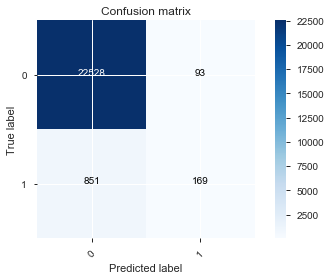

In [495]:
logreg_first.plot_confusion_matrix()

There are many errors type 'False positive'

Balanced data

In [158]:
param_grid = [{
    'C':[100],
    }]
logreg_firstsem = TestModels(LogisticRegression(),
                    Xsem, ysem, X_test1, Y_test1, params=None)

In [159]:
logreg_firstsem.fit_model()

E:\Soft\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(array([0., 0., 0., ..., 0., 0., 0.]),
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False))

In [160]:
logreg_firstsem.show_metrics()

ROC_AUC score on dev:         0.864275554977709
Accuracy score on dev:        0.8265301806184172
F1 score on dev:              0.2809047869542346
Precision score on dev:       0.17289013598100583
Accuracy score on train:      0.8051508462104489
Precision score on train:     0.8208361700810795


Confusion matrix, without normalization
[[18739  3832]
 [  269   801]]


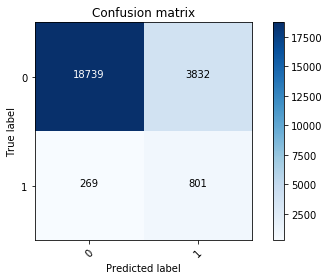

In [161]:
logreg_firstsem.plot_confusion_matrix()

There are many errors type 'False negative'

# 3.2 RandomForest

In [508]:
forest_all = TestModels(RandomForestClassifier(n_estimators=50, max_depth=40),
                    X_train, Y_train, X_test, Y_test, params=None)

In [509]:
forest_all.fit_model()

E:\Soft\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


(array([0., 0., 0., ..., 0., 0., 0.]),
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=40, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False))

In [510]:
forest_all.show_metrics()

ROC_AUC score on dev:         0.914864723131638
Accuracy score on dev:        0.9685292500317245
F1 score on dev:              0.4320610687022901
Precision score on dev:       0.9758620689655172
Accuracy score on train:      0.9991681001663799
Precision score on train:     1.0


Confusion matrix, without normalization
[[22614     7]
 [  737   283]]


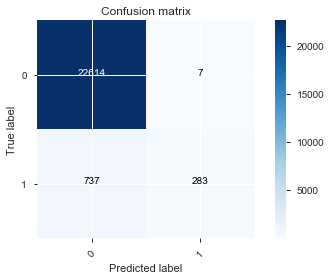

In [511]:
forest_all.plot_confusion_matrix()

There are many errors type 'False positive'

In [166]:

forest = TestModels(RandomForestClassifier(n_estimators=100, max_depth=40, max_features=150),
                    X_train, Y_train, X_test, Y_test, params=None)

In [167]:
forest.fit_model()

E:\Soft\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


(array([0., 0., 0., ..., 0., 0., 0.]),
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=40, max_features=150, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False))

In [168]:
forest.show_metrics()

ROC_AUC score on dev:         0.9142449061196208
Accuracy score on dev:        0.9706019203925383
F1 score on dev:              0.537591483699268
Precision score on dev:       0.8763557483731019
Accuracy score on train:      0.99905530018894
Precision score on train:     1.0


Confusion matrix, without normalization
[[22542    57]
 [  638   404]]


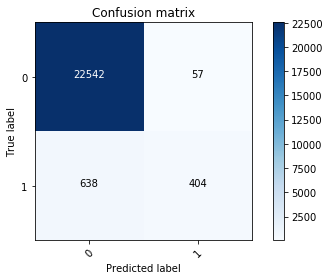

In [169]:
forest.plot_confusion_matrix()

There are many errors type 'False positive'

Balanced data

In [51]:
forest_all_bal = TestModels(RandomForestClassifier(n_estimators=100, max_depth=42),
                    Xsem, ysem, X_test1, Y_test1, params=None)

In [52]:
forest_all_bal.fit_model()

E:\Soft\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


(array([0., 0., 0., ..., 0., 0., 0.]),
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=42, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False))

In [53]:
forest_all_bal.show_metrics()

ROC_AUC score on dev:         0.9210760220440941
Accuracy score on dev:        0.9700943276511146
F1 score on dev:              0.5441650548033526
Precision score on dev:       0.82421875
Accuracy score on train:      1.0
Precision score on train:     1.0


Confusion matrix, without normalization
[[22512    90]
 [  617   422]]


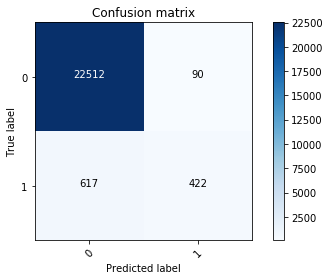

In [54]:
forest_all_bal.plot_confusion_matrix()

# 3.3 GradientBoostingClassifier

In [42]:
boosting = TestModels(GradientBoostingClassifier(n_estimators=100,max_depth=6),
                    X_train, Y_train, X_test, Y_test, params=None)

In [43]:
boosting.fit_model()

E:\Soft\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(array([0., 0., 0., ..., 0., 0., 0.]),
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=6,
               max_features=None, max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=100,
               presort='auto', random_state=None, subsample=1.0, verbose=0,
               warm_start=False))

In [44]:
boosting.show_metrics()

ROC_AUC score on dev:         0.9083961046974459
Accuracy score on dev:        0.9659912863246055
F1 score on dev:              0.4530612244897959
Precision score on dev:       0.7780373831775701
Accuracy score on train:      0.9781168043766392
Precision score on train:     0.9564943253467844


Confusion matrix, without normalization
[[22504    95]
 [  709   333]]


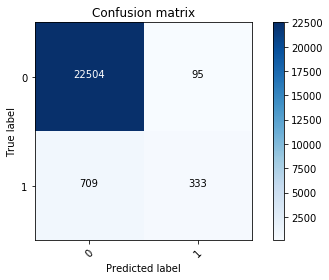

In [45]:
boosting.plot_confusion_matrix()

There are many errors type 'False positive'

Balanced data

In [141]:
boostingsem = TestModels(GradientBoostingClassifier(n_estimators=100,max_depth=6),
                    Xsem, ysem, X_test1, Y_test1, params=None)

In [142]:
boostingsem.fit_model()

E:\Soft\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(array([0., 0., 0., ..., 0., 0., 0.]),
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=6,
               max_features=None, max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=100,
               presort='auto', random_state=None, subsample=1.0, verbose=0,
               warm_start=False))

In [143]:
boostingsem.show_metrics()

ROC_AUC score on dev:         0.9272849910376271
Accuracy score on dev:        0.9036419779197158
F1 score on dev:              0.42561775088250126
Precision score on dev:       0.2914364640883978
Accuracy score on train:      0.9069168506254599
Precision score on train:     0.9115563229340319


Confusion matrix, without normalization
[[20519  2052]
 [  226   844]]


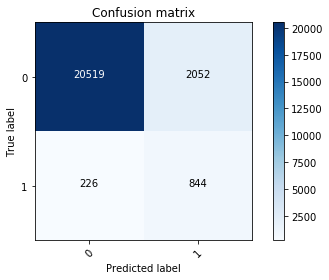

In [144]:
boostingsem.plot_confusion_matrix()

There are many errors type 'False negative'

# 3.4 KNeighborsClassifier

In [26]:
param_grid = [{
    'n_neighbors':2,
    }]
kmeans = TestModels(KNeighborsClassifier(),
                    X_train, Y_train, X_test, Y_test, params=None)

In [27]:
kmeans.fit_model()

E:\Soft\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


(array([0., 0., 0., ..., 0., 0., 0.]),
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=1, n_neighbors=5, p=2,
            weights='uniform'))

In [28]:
kmeans.show_metrics()

ROC_AUC score on dev:         0.5391371862356985
Accuracy score on dev:        0.9564739224229094
F1 score on dev:              0.03198494825964252
Precision score on dev:       0.3617021276595745
Accuracy score on train:      0.9585037082992584
Precision score on train:     0.754601226993865


Confusion matrix, without normalization
[[22595    30]
 [  999    17]]


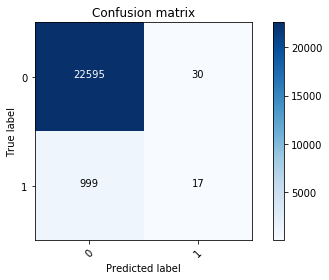

In [31]:
kmeans.plot_confusion_matrix()

In [33]:
param_grid = [{
    'n_neighbors':2,
    }]
kmeans2 = TestModels(KNeighborsClassifier(),
                    Xsem, ysem, X_test1, Y_test1, params=None)

In [34]:
kmeans2.fit_model()

E:\Soft\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


(array([0., 0., 0., ..., 0., 0., 0.]),
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=1, n_neighbors=5, p=2,
            weights='uniform'))

Confusion matrix, without normalization
[[21231  1371]
 [  359   680]]


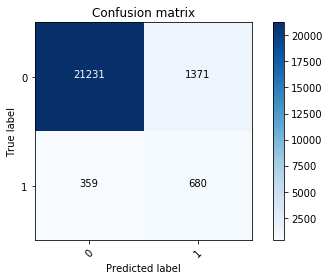

In [36]:
kmeans2.plot_confusion_matrix()

# 4. Best model is Random Forest. F_score = 55%

# Test models with n best features

In [ ]:
X = data.iloc[:,1: 193 ]
Y = data.loc[:, "fraud"]
lr = LinearRegression()
#select n the most informative features
rfe = RFE(lr, n) 
selector = rfe.fit(X,Y)

Select columns with correlations > 0.05

In [142]:
corr_meaning = pd.DataFrame(corr.loc[:, 'fraud'])
corr_meaning = corr_meaning[corr_meaning.fraud > 0.05]
feature = list(corr_meaning.index)

len(feature)

69

In [146]:
data_n = data.loc[:, feature]

In [147]:
data_n.head()

feature_8  feature_9  feature_15  feature_16  feature_20  feature_22  \
0        1.0        0.0         1.0         1.0         1.0         1.0   
1        0.0        0.0         0.0         0.0         0.0         0.0   
2        1.0        0.0         0.0         0.0         0.0         0.0   
3        1.0        0.0         1.0         0.0         0.0         0.0   
4        1.0        0.0         0.0         0.0         0.0         0.0   

   feature_32  feature_37  feature_38  feature_39  ...    feature_184  \
0         0.0         1.0         2.0         2.0  ...            4.0   
1         0.0         0.0         0.0         0.0  ...            1.0   
2         0.0         0.0         0.0         0.0  ...            1.0   
3         0.0         0.0         0.0         0.0  ...            1.0   
4         0.0         1.0         2.0         2.0  ...            1.0   

   feature_185  feature_186  feature_187  feature_188  feature_189  \
0          2.0          1.0          1.0         12.0         12.0   
1          1.0          1.0          1.0          1.0          1.0   
2          1.0          1.0          1.0          1.0          1.0   
3          1.0          1.0          1.0          2.0          2.0   
4          1.0          1.0          1.0          3.0          3.0   

   feature_190  feature_191  feature_192  fraud  
0          1.0         12.0         12.0    0.0  
1          1.0          1.0          1.0    0.0  
2          1.0          1.0          1.0    0.0  
3          1.0          2.0          2.0    0.0  
4          1.0          3.0          3.0    0.0  

[5 rows x 69 columns]

In [149]:
feature_to_scal_n = pd.DataFrame(data_n.describe().loc['max', :][data_n.describe().loc['max', :] > 1])

In [150]:
val_n = list(feature_to_scal_n.index)

In [152]:
data_n[val_n] = minmax_scale(data_n[val_n])

In [153]:
data_n.describe()

feature_8     feature_9    feature_15    feature_16    feature_20  \
count  94563.000000  94563.000000  94563.000000  94563.000000  94563.000000   
mean       0.749363      0.159502      0.319882      0.076182      0.086968   
std        0.433382      0.366146      0.466433      0.265291      0.281790   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        1.000000      0.000000      0.000000      0.000000      0.000000   
75%        1.000000      0.000000      1.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

         feature_22    feature_32    feature_37    feature_38    feature_39  \
count  94563.000000  94563.000000  94563.000000  94563.000000  94563.000000   
mean       0.033967      0.027135      0.063425      0.013001      0.015798   
std        0.181145      0.162479      0.131958      0.040754      0.049077   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

           ...        feature_184   feature_185   feature_186   feature_187  \
count      ...       94563.000000  94563.000000  94563.000000  94563.000000   
mean       ...           0.071484      0.132226      0.093815      0.045916   
std        ...           0.037647      0.067407      0.050177      0.035952   
min        ...           0.000000      0.000000      0.000000      0.000000   
25%        ...           0.076923      0.142857      0.111111      0.052632   
50%        ...           0.076923      0.142857      0.111111      0.052632   
75%        ...           0.076923      0.142857      0.111111      0.052632   
max        ...           1.000000      1.000000      1.000000      1.000000   

        feature_188   feature_189   feature_190   feature_191   feature_192  \
count  94563.000000  94563.000000  94563.000000  94563.000000  94563.000000   
mean       0.026241      0.027432      0.119796      0.028878      0.023762   
std        0.039880      0.049211      0.060850      0.045405      0.045608   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.021277      0.018868      0.142857      0.021277      0.015625   
50%        0.021277      0.018868      0.142857      0.021277      0.015625   
75%        0.021277      0.018868      0.142857      0.021277      0.015625   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

              fraud  
count  94563.000000  
mean       0.042744  
std        0.202280  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000  

[8 rows x 69 columns]

In [154]:
data_n.shape

(94563, 69)

In [157]:
X_n = pd.DataFrame(data_n.iloc[:, :68])
y_n = pd.DataFrame(data_n.loc[:, 'fraud'])

In [159]:
X_train_n, X_test_n, Y_train_n, Y_test_n = train_test_split(X_n, y_n)

In [161]:
forestn = TestModels(RandomForestClassifier(n_estimators=100, max_depth=40),
                    X_train_n, Y_train_n, X_test_n, Y_test_n, params=None)

In [162]:
forestn.fit_model()

E:\Soft\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


(array([0., 0., 0., ..., 0., 0., 0.]),
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=40, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False))

Confusion matrix, without normalization
[[22500   137]
 [  777   227]]


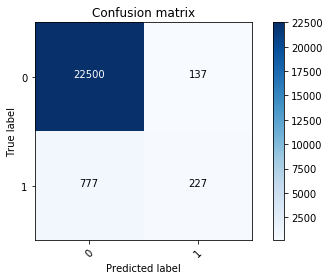

In [163]:
forestn.plot_confusion_matrix()

# We should use all features.